This notebook contains code for running logistic regression with & without violation type as variables, and filtering to speeding only records. The target variable is **contraband found**.

> *Import Libraries and Mount Drive*




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> *Data Format: split data file based on year, one parquet file per year* -> **RUN THIS ONLY ONCE**

In [3]:
# # SPECIFY DATA PATH HERE
# path = '/content/drive/MyDrive/traffic_stop/traffic.parquet'
# data = pd.read_parquet(path, engine = 'pyarrow')

In [4]:
# data['year'] = pd.DatetimeIndex(data['date']).year
# year_start= min(data['year'].unique())
# year_end= max(data['year'].unique())
# #year_start = 2006
# #year_end = 2017
# years = list(range(year_start, year_end + 1))
# # split data file based on year
# for year in years:
#   data_write = data[data['year'] == year]
#   file_name = 'traffic_' + str(year)
#   # SPECIFY DATA PATH FOR YEARLY DATA FILE HERE
#   year_path = '/content/drive/MyDrive/traffic_stop/year_data/' + file_name + '.parquet'
#   data_write.to_parquet(year_path, engine='pyarrow')

> *Sanity Check and Get Parameters*

In [5]:
# columns we need in the analysis
keep_col = [
            'county_name', 
            'subject_race',
            'subject_sex',
            'violation', 
            'contraband_found',
            #'search_conducted'
            ]

def sanity_check(year):
  df = pd.read_parquet('/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet')

  # print columns, check if the columns we need are in the data
  print('****************************')
  print('Columns in the data: ')
  print(df.columns)
  print('****************************')

  # check missing value proportions
  print('Missing value proportions for columns that we need:')
  percent_missing = df[keep_col].isnull().sum() * 100 / len(df)
  #missing_value_df = pd.DataFrame({'column_name': df[keep_col].columns,
                                 #'percent_missing': percent_missing})
  print(percent_missing)
  print('****************************')
  # check distribution of contraband found, race, and sex: make sure it is a relatively representative sample
  print(df['contraband_found'].value_counts(dropna = False))
  print('****************************')
  print(df['subject_sex'].value_counts(dropna = False))
  print('****************************')
  print(df['subject_race'].value_counts(dropna = False))

In [6]:
sanity_check(2015)

****************************
Columns in the data: 
Index(['raw_row_number', 'date', 'time', 'location', 'lat', 'lng',
       'county_name', 'district', 'precinct', 'region', 'subject_race',
       'subject_sex', 'officer_id_hash', 'type', 'violation',
       'citation_issued', 'warning_issued', 'outcome', 'contraband_found',
       'contraband_drugs', 'contraband_weapons', 'search_conducted',
       'search_vehicle', 'search_basis', 'vehicle_color', 'vehicle_make',
       'vehicle_model', 'vehicle_type', 'vehicle_year', 'raw_HA_RACE_SEX',
       'raw_HA_SEARCH_PC_boolean', 'raw_HA_SEARCH_CONCENT_boolean',
       'raw_HA_INCIDTO_ARREST_boolean', 'raw_HA_VEHICLE_INVENT_boolean',
       'year'],
      dtype='object')
****************************
Missing value proportions for columns that we need:
county_name          0.000000
subject_race         0.000000
subject_sex          0.001375
violation            0.000000
contraband_found    98.525769
dtype: float64
****************************
N

In [7]:
def contraband_na(year):
  df = pd.read_parquet('/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet')
  df = df[df['search_conducted']== True]
  #df['contraband_found'].fillna(False, inplace = True)
  print(df.contraband_found.unique())

In [8]:
contraband_na(2017)

#2017 - > all empty strings since all of search_conducted=False. 
#It will also give rise to "complete perfect separation"

[]


In [9]:
def checking(year):
  df = pd.read_parquet('/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet')
  df_new = pd.crosstab(df['raw_row_number'], [df['subject_sex'], df['subject_race']], dropna=False)
  df_new.columns = ['_'.join(map(str, x)) for x in df_new.columns]
  df_new.reset_index(inplace=True)
  df = df.merge(df_new, how='left', on=['raw_row_number'])
  print(df)


In [10]:
#checking(2007) 

> **Logistic Regression Without Violation Types**
 1.   variables included: race variables, metropolitan, gender

> **Logistic Regression With Violation Types**
1. variables included: race variables, metropolitan, gender, violation type dummies (common type dummies + 'others' category)
2. common violation types defined based on 'threshold' parameter: # of records required in each year

> **Logistic Regression With Speeding-only records**
1. variables included: race variables, metropolitan, gender
2. filter rows to include speeding-only violations

In [11]:
def single_vio_types(threshold, year_start, year_end):
  """
  data format: violation type in data end with ' (#)'; more than 1 violation types: 'A|B'
  returns a list of violation types with # of single violation records > threshold every year
  """
  year_present_vios = {}
  years = list(range(year_start, year_end + 1))

  # get number of years in which a specific violation having # of single violation records more than threshold

  for year in years:
    print('Processing: ',year)
    df = pd.read_parquet('/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet')

    cnt_df = pd.DataFrame(df['violation'].value_counts(dropna=False))
    
    cnt_df = cnt_df.loc[cnt_df['violation'] > threshold]
    single_vio_lst = [vio for vio in list(cnt_df.index) if '|' not in vio]

    for vio in single_vio_lst:
      if vio not in year_present_vios:
        year_present_vios[vio] = 1
      else:
        year_present_vios[vio] += 1

  vio_type_all = []
  for vio, cnt in year_present_vios.items():
    if cnt == len(years):
      vio_type_all.append(vio)
  vio_type_all = [vio.replace(' (#)', '').strip() for vio in vio_type_all]

  return vio_type_all

In [12]:
year_start = 2006
year_end = 2017
# vio_vars used in preprocessing()
vio_vars = single_vio_types(threshold = 5000, year_start = year_start, year_end = year_end)
print("# of single violation types: ", len(vio_vars))
vio_vars

Processing:  2006
Processing:  2007
Processing:  2008
Processing:  2009
Processing:  2010
Processing:  2011
Processing:  2012
Processing:  2013
Processing:  2014
Processing:  2015
Processing:  2016
Processing:  2017
# of single violation types:  22


['Speeding Over Limit',
 'Speeding-10% or More Above Posted Speed',
 'No/Improper License Plate Lamp',
 'Ride, Not Secured By Safety Belt-Driver (12-1-85)',
 'Operate Motor Vehicle Without License Plates (Or With One Plate)',
 'No/Non-Compliant Head Lamps',
 'Improperly Placed Or Obstructed License Plate',
 'Display Expired License Plates/Registration',
 'No/Improper Mud Flap',
 'No/Improper Tail Lamp - not Motorcycle',
 'Following Too Closely',
 'Drive On Improved Shoulder When Prohibited',
 'Fail To Signal Lane Change',
 'Disregard Stop Sign',
 'Fail To Drive In Single Lane',
 'Ride, Not Secured By Safety Belt-Passenger (When Required)',
 'Fail to Move Over or Slow Down for Certain Vehicles',
 'Inoperable/Obscured Stop Lamp(s)',
 'Use Of Vision Reducing Matter On Windows - Glass Coating Material',
 'Unsafe Speed',
 'Fail To Control Speed',
 'Drive in Left Lane When Not Passing or Where Prohibited']

In [13]:
# this function is called by preprocess(year, keep_col, rm_na_col, violation_types)
def get_vio_df(violation_types, vio_col):
  """
  function to generate dummy encoding of violation types
  PARAMS:
  violation_types: single violation types with # of records each year > threshold, obtained from single_vio_types(threshold, year_start, year_end)
  vio_col: violation type column in data file
  """

  vio_df_dict  = {vio: [] for vio in violation_types}
  vio_df_dict['others'] = []

  for vio in vio_col:
    vio_lst = vio.split('|')
    vio_lst = [vio.replace(' (#)', '').strip() for vio in vio_lst]
    # if single violation
    if len(vio_lst) == 1:
      vio = vio.replace(' (#)', '').strip()
      # if vio in violation_types
      if vio in violation_types:
        vio_df_dict[vio].append(1)
        vio_df_dict['others'].append(0)
        for vio_var in violation_types:
          if vio_var != vio:
            vio_df_dict[vio_var].append(0)

      # if vio not in violation_types
      else:
        vio_df_dict['others'].append(1)
        for vio_var in violation_types:
          vio_df_dict[vio_var].append(0)
    
    # if multiple violations
    if len(vio_lst) > 1:

      # for single vio variables
      for vio_var in violation_types:
        # if has one of violation_types
        if vio_var in vio_lst:
          vio_df_dict[vio_var].append(1)
        # if violation_type not present
        else:
          vio_df_dict[vio_var].append(0)

      # for the 'others' variable
      # if have one vio not in violation_types, 'other' = 1
      vars_vio_cnt = 0
      for violation in vio_lst:
        if violation not in violation_types:
          vio_df_dict['others'].append(1)
          break
        else:
          vars_vio_cnt += 1
      # if all violations of this record in violation_types
      if vars_vio_cnt == len(vio_lst):
        vio_df_dict['others'].append(0)

  vio_df = pd.DataFrame(vio_df_dict)
  vio_df['violation'] = vio_col.values

  return vio_df

> *Function to help filter speeding-only: speeding_filter() used in preprocess()*

In [14]:
def remove_duplicates(row):
  if row['speeding_only'] == 'speeding-repeated_entries':
    return row['all_violation'][0].strip()
  else:
    return row['violation']

def remove_white_spaces(vio_lst):
  vio_lst = [x.strip() for x in vio_lst]
  return vio_lst
  
def exclusive(vio_lst):
  count = 0
  for vio in vio_lst:
    # count number of violations containing 'speed'
    if 'speed' in vio:
      count += 1
  # if we have non-speeding violation
  if count < len(vio_lst):
    return 'speeding + others'
  # if we only have speeding violation
  elif count == len(vio_lst):
    # if one speeding vio type
    if count == 1:
      return 'speeding-1'
    # if we have more than one entries but only one type
    elif len(set(vio_lst)) == 1:
      return 'speeding-repeated_entries'
    # if we have more than one type
    else:
      return 'speeding-multiple'
  else:
    return 'undefined case'

In [15]:
def speeding_filter(df):
  print('Before speed filtering: ', len(df))
  df['violation'] = [s.lower() for s in df['violation']]
  # at least one violation is speeding-violated (could have other violations at the same time)
  df = df.loc[df['violation'].str.contains('speed', regex = False),:]
  df['violation'] = df['violation'].map(lambda x: x.replace('(#)',''))
  df['violation'] = df['violation'].map(lambda x: x.strip())

  # get a list of violations for each record, and apply self-defined func exclusive
  df['all_violation'] = df['violation'].str.split('|')
  df['all_violation'] = df['all_violation'].map(lambda x: remove_white_spaces(x))
  df['speeding_only'] = df['all_violation'].map(lambda x: exclusive(x))

  # filter out rows with violations other than speeding
  df = df.loc[df['speeding_only'].isin(['speeding-repeated_entries','speeding-1','speeding-multiple']),:]

  df['violation'] = df.apply(lambda row: remove_duplicates(row), axis = 1)

  df.drop(['all_violation','speeding_only'], axis = 1, inplace = True)
  print('Speeding only violation has records: ', len(df))
  return df

In [16]:
# columns we need in the analysis
keep_col = [
            'county_name', 
            'subject_race',
            'subject_sex',
            'violation', 
            'contraband_found',
            #'search_conducted'
            ]

# delete rows with missing value in these columns           
rm_na_col = ['county_name','violation','subject_race','subject_sex']

# this function is called by preprocess
def remove_empty_rows(df, colName):
	df = df[df[colName] != 'unknown']

	df = df[df[colName].notna()]
	return(df)

The whole **metropolitan block** needs to change: the new state's data file path and preprocessing and join.

In [17]:
### this function used in run_year_analysis()
def preprocess(year, keep_col, rm_na_col, with_vio = False, violation_types=None, speeding_only = False):
  """
  with_vio: if include vioation type variables: True, if not include, False
  violation_types: violation types to be included in the analysis
  """
  # read dataframe
  filename = '/content/drive/MyDrive/traffic_stop/year_data/traffic_' + str(year) + '.parquet'
  df = pd.read_parquet(filename, engine = 'pyarrow')
  print('# of all traffic stops in year ', year, ': ', len(df))

  # invalid value (IF NOT TEXAS STATE DATA, DELETE THIS INVALID VALUE BLOCK)
  if year == 2013:
    df.drop(df.index[df['lat'] == 74.052879], inplace=True)

  # drop unrelated columns
  col_drop = [col for col in df.columns if col not in keep_col]
  df.drop(col_drop, axis = 1, inplace = True)

  # remove rows with missing values in rm_na_col
  for col in rm_na_col:
    df = remove_empty_rows(df, col)

  # filter rows if speeding_only
  if speeding_only:
    # filter: only speeding violation (no other violations) 
    df = speeding_filter(df)

  ######### THIS WHOLE BLOACK NEEDS TO BE CHANGED, NEW METROPOLITAN FILES AND DIFFERENT DATA FORMAT #########

  # County names are converted to county type - metropolitan, micropolitan or non-core
  # For definitions, see US OMB website

  # read in county info csv
  county_df = pd.read_csv('/content/drive/MyDrive/traffic_stop/2014-2018.csv')
  county_df = county_df[county_df['State']=='Texas']
  county_df = county_df.filter(items=['Metropolitan Status', 'County Name'])

  # transform column
  df['county'] = [name[:-7] for name in df['county_name']]
  df['county'] = df['county'].replace('Dewitt','DeWitt')
  df = df.join(county_df.set_index('County Name'), on='county')
  df.drop('county', axis = 1, inplace=True)
  df.rename(columns={'Metropolitan Status':'county_type'}, inplace=True)

  ######### Metropolitan block ends here #########


  df = df.dropna(subset= ['contraband_found'])
 
  # To reset the indices
  df = df.reset_index(drop = True)
  # Convert 'contraband_found' to integer
  
  df = df.astype({'contraband_found': 'int64'})

  # if race is other/unknown, we delete the rows!
  df = df.loc[(df['subject_race'] != 'unknown') & (df['subject_race'] != 'other'),:]
  df['subject_race'] = df.subject_race.cat.remove_unused_categories()

  # crosstab feature
  df_new = pd.crosstab(df['violation'], [df['subject_sex'], df['subject_race']], dropna=False)
  df_new.columns = ['_'.join(map(str, x)) for x in df_new.columns]
  df_new.reset_index(inplace=True)
  df = df.merge(df_new, how='left', on=['violation'])
  df.drop(['county_name'], axis = 1, inplace = True)
  
  

  if with_vio:

    # get violation variables
    vio_df = get_vio_df(violation_types, vio_col = df['violation'])
    vio_df.drop('violation', axis = 1, inplace = True)

    # other x variables get dummies
    y = df['contraband_found']
    df.drop(['violation','contraband_found'], axis = 1, inplace = True)
    df = pd.get_dummies(df)
    df.drop(['subject_race_white', 'male_white', 'county_type_Metropolitan', 'subject_sex_male', 'subject_race_black','subject_race_hispanic','subject_race_asian/pacific islander','subject_sex_female'], axis = 1, inplace = True)

    #vio_df.drop('Speeding Over Limit', axis = 1, inplace = True), I don't think vio_type needs a base level, as no multicollinearity
    df.reset_index(drop=True, inplace=True)
    vio_df.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    X = pd.concat([df, vio_df], axis = 1)
    X.columns = list(df.columns) + list(vio_df.columns)

    print('# of traffic stops after preprocessing in year ', year, ': ', len(X))
    return (y, X)

  elif not with_vio:

    # other x variables get dummies
    y = df['contraband_found']
    df.drop(['violation','contraband_found'], axis = 1, inplace = True)
    df = pd.get_dummies(df)
    df.drop(['subject_race_white', 'male_white', 'county_type_Metropolitan', 'subject_sex_male', 'subject_race_black','subject_race_hispanic','subject_race_asian/pacific islander','subject_sex_female'], axis = 1, inplace = True)
    
    df.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    print('# of traffic stops after preprocessing in year ', year, ': ', len(df))
    return (y, df)

We assume in the data, race info is recorded in the column **'subject_race'**, with values **white, black, hispanic, asian/pacific islander**. -> pd.get_dummies() used in preprocess gives us variables like subject_race_black.

In some states' data, race info column name may be different and race categories may be different. In this case, the function **run_year_analysis** needs to change the **last three code blocks** with comments: # append race coefs to result list for plotting, # lower CI, and # upper CI to race column name + '_' + race category.

The function above: **preprocessing() needs to change accordingly** as well. (where we drop base levels, use subject_race as the column name, etc.)

In [18]:
### this function used in generate_outputs()
def run_year_analysis(keep_col, rm_na_col, df_years, with_vio = False, violation_types=None, speeding_only = False):
  """
  param:
  violation_types: violation types to be included in the analysis

  Output:
  A result dataframe
  """
  years = list(range(year_start, year_end+1))

  for year in years:
    # read in the data
    print('***********************************')
    print(year)

    # read in and preprocess data
    y, X = preprocess(year, keep_col, rm_na_col, with_vio, violation_types, speeding_only)
    
    #adding constant to X
    X_with_constant = sm.add_constant(X)
    # building the model and fitting the data
    log_reg = sm.Logit(y, X_with_constant).fit()
    
    res_df = pd.DataFrame({'variable':list(log_reg.params.index), 'coef':list(log_reg.params.values), 
                           'odds_ratio':list(np.exp(log_reg.params.values)),
                           'lower_CI':list(np.exp(log_reg.conf_int()[0].values)),
                           'upper_CI':list(np.exp(log_reg.conf_int()[1].values)),'pvalue':list(log_reg.pvalues)})

    df_years = df_years.merge(res_df, left_on = 'variable', right_on = 'variable', how = 'outer')
    df_years = df_years.rename(columns = {'coef': ('coef_' + str(year)), 
                                          'odds_ratio': ('odds_ratio_' + str(year)),
                                          'lower_CI': ('OR_lower_CI_' + str(year)),
                                          'upper_CI': ('OR_upper_CI_' + str(year)), 
                                          'pvalue': ('pvalue_' + str(year))})

    # append race coefs to result list for plotting
    female_white.append(np.exp(log_reg.params['female_white']))
    male_black.append(np.exp(log_reg.params['male_black']))
    female_black.append(np.exp(log_reg.params['female_black']))
    male_hispanic.append(np.exp(log_reg.params['male_hispanic']))
    female_hispanic.append(np.exp(log_reg.params['female_hispanic']))
    male_asianpacific.append(np.exp(log_reg.params['male_asian/pacific islander']))
    female_asianpacific.append(np.exp(log_reg.params['female_asian/pacific islander']))

    # lower CI
    female_white_low.append(np.exp(log_reg.conf_int()[0]['female_white']))
    male_black_low.append(np.exp(log_reg.conf_int()[0]['male_black']))
    female_black_low.append(np.exp(log_reg.conf_int()[0]['female_black']))
    male_hispanic_low.append(np.exp(log_reg.conf_int()[0]['male_hispanic']))
    female_hispanic_low.append(np.exp(log_reg.conf_int()[0]['female_hispanic']))
    male_asianpacific_low.append(np.exp(log_reg.conf_int()[0]['male_asian/pacific islander']))
    female_asianpacific_low.append(np.exp(log_reg.conf_int()[0]['female_asian/pacific islander']))

    # upper CI
    female_white_high.append(np.exp(log_reg.conf_int()[1]['female_white']))
    male_black_high.append(np.exp(log_reg.conf_int()[1]['male_black']))
    female_black_high.append(np.exp(log_reg.conf_int()[1]['female_black']))
    male_hispanic_high.append(np.exp(log_reg.conf_int()[1]['male_hispanic']))
    female_hispanic_high.append(np.exp(log_reg.conf_int()[1]['female_hispanic']))
    male_asianpacific_high.append(np.exp(log_reg.conf_int()[1]['male_asian/pacific islander']))
    female_asianpacific_high.append(np.exp(log_reg.conf_int()[1]['female_asian/pacific islander']))

  return df_years

# write result df to csv file

> *Function to output coefficient estimate & odds ratio csv files and odds ratio figures*

If including violation type variables, set with_vio = true, violation_types = what you get from single_vio_types(threshold, year_start, year_end).

If not including violation type variables, set as default: with_vio = False, violation_types = None.

In [19]:
def generate_outputs(folder_path, with_vio = False, violation_types = None, speeding_only = False):
  """
  function outputs a csv file, a jpg and an svg figure
  PARAMS:
  folder path: eg., '/gdrive/MyDrive/traffic_stop/output_0502/' 
  """
  # columns to store
  var_lst_baseline = ['male_black', 'female_black', 'male_hispanic', 'male_asian/pacific islander',
                      'female_hispanic', 'female_asian/pacific islander', 'female_white',                  
                      'county_type_Non core', 'county_type_Micropolitan']

  df_years = pd.DataFrame({'variable':var_lst_baseline})

  if not with_vio:
    res_df = run_year_analysis(keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years, with_vio = False, violation_types = None, speeding_only = speeding_only)
  else:
    res_df = run_year_analysis(keep_col = keep_col, rm_na_col = rm_na_col, df_years = df_years, with_vio = True, violation_types = violation_types)
  
  # save csv
  if speeding_only:
    file_name = 'ORCBFInter_speeding.csv'
  elif not speeding_only:
    if with_vio:
      file_name = 'ORCBFInter_with_vios.csv'
    else:
      file_name = 'ORCBFInter_no_vios.csv'

  # CHANGE THE PATH
  save_path = folder_path + file_name
  res_df.to_csv(save_path, index = False)

  years = list(range(year_start, year_end + 1))
  sns.lineplot(x = years, y = male_black, color = 'red', label="Male-Black")
  sns.lineplot(x = years, y = female_black, color = 'plum', label="Female-Black")
  sns.lineplot(x = years, y = male_hispanic, color = 'blue', label="Male-Hispanic")
  sns.lineplot(x = years, y = female_hispanic, color = 'green', label="Female-Hispanic")
  sns.lineplot(x = years, y = male_asianpacific, color = 'aqua', label="Male-Asian/Pacific Islander")
  sns.lineplot(x = years, y = female_asianpacific, color = 'coral', label="Female-Asian/Pacific Islander")
  sns.lineplot(x = years, y = female_white, color = 'chocolate', label="Female-White")

  sns.lineplot(x = years, y = male_black_low, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = female_black_low, color = 'plum', linestyle='--')
  sns.lineplot(x = years, y = male_hispanic_low, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = female_hispanic_low, color = 'green', linestyle='--')
  sns.lineplot(x = years, y = male_asianpacific_low, color = 'aqua', linestyle='--')
  sns.lineplot(x = years, y = female_asianpacific_low, color = 'coral', linestyle='--')
  sns.lineplot(x = years, y = female_white_low, color = 'chocolate', linestyle='--')

  sns.lineplot(x = years, y = male_black_high, color = 'red', linestyle='--')
  sns.lineplot(x = years, y = female_black_high, color = 'plum', linestyle='--')
  sns.lineplot(x = years, y = male_hispanic_high, color = 'blue', linestyle='--')
  sns.lineplot(x = years, y = female_hispanic_high, color = 'green', linestyle='--')
  sns.lineplot(x = years, y = male_asianpacific_high, color = 'aqua', linestyle='--')
  sns.lineplot(x = years, y = female_asianpacific_high, color = 'coral', linestyle='--')
  sns.lineplot(x = years, y = female_white_high, color = 'chocolate', linestyle='--')

  plt.xlabel('Year')
  plt.ylabel('Odds Ratio')
  plt.legend(["Male-Black", "Female-Black", "Male-Hispanic", "Female-Hispanic" , "Male-Asian/Pacific Islander", "Female-Asian/Pacific Islander", "Female-White"],
           bbox_to_anchor = (1.05, 0.6))


  # CHANGE THE PATH HERE
  figure_name1 = file_name.replace('csv', 'svg')
  figure_name2 = file_name.replace('csv', 'jpg')
  figure_name3 = file_name.replace('csv', 'pdf')
  plt.savefig((folder_path+figure_name1), format = 'svg', bbox_inches="tight")
  plt.savefig((folder_path+figure_name2), dpi = 200, bbox_inches="tight")
  plt.savefig((folder_path+figure_name3), format="pdf", bbox_inches="tight")

  plt.show()


> **WITHOUT VIOLATION TYPE VARIABLES**

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing in year  2006 :  84402
Optimization terminated successfully.
         Current function value: 0.511513
         Iterations 7
***********************************
2007
# of all traffic stops in year  2007 :  2427347
# of traffic stops after preprocessing in year  2007 :  74972
Optimization terminated successfully.
         Current function value: 0.495552
         Iterations 7
***********************************
2008
# of all traffic stops in year  2008 :  2526783
# of traffic stops after preprocessing in year  2008 :  61017
Optimization terminated successfully.
         Current function value: 0.488800
         Iterations 8
***********************************
2009
# of all traffic stops in year  2009 :  2441306
# of traffic stops after preprocessing in year  2009 :  44441
Optimization terminated successfully.
         Current function value: 0.501703
         I

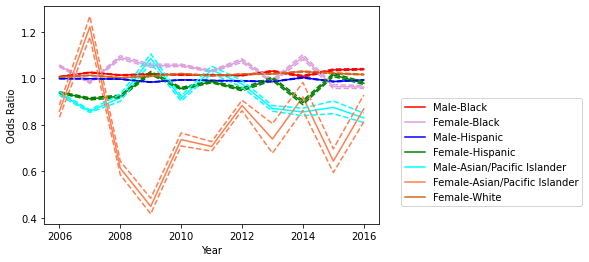

In [20]:
# keep track of coefficient estimates and evaluation metrics
year_end = 2016
male_black = []
female_black = []	
male_asianpacific = []
female_asianpacific = []
male_hispanic = []
female_hispanic = []
female_white = []

male_black_low = []
female_black_low = []	
male_asianpacific_low = []
female_asianpacific_low = []
male_hispanic_low = []
female_hispanic_low = []
female_white_low = []

male_black_high = []
female_black_high = []	
male_asianpacific_high = []
female_asianpacific_high = []
male_hispanic_high = []
female_hispanic_high = []
female_white_high = []

generate_outputs(folder_path ='/content/drive/MyDrive/traffic_stop/output_inter/', with_vio = False, violation_types = None)

> **WITH VIOLATION TYPE VARIABLES**

***********************************
2006
# of all traffic stops in year  2006 :  2693894
# of traffic stops after preprocessing in year  2006 :  84402
Optimization terminated successfully.
         Current function value: 0.488783
         Iterations 7
***********************************
2007
# of all traffic stops in year  2007 :  2427347
# of traffic stops after preprocessing in year  2007 :  74972
Optimization terminated successfully.
         Current function value: 0.478865
         Iterations 7
***********************************
2008
# of all traffic stops in year  2008 :  2526783
# of traffic stops after preprocessing in year  2008 :  61017
Optimization terminated successfully.
         Current function value: 0.463295
         Iterations 7
***********************************
2009
# of all traffic stops in year  2009 :  2441306
# of traffic stops after preprocessing in year  2009 :  44441
Optimization terminated successfully.
         Current function value: 0.466113
         I

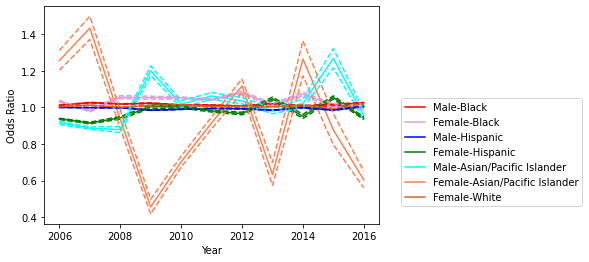

In [21]:
male_black = []
female_black = []	
male_asianpacific = []
female_asianpacific = []
male_hispanic = []
female_hispanic = []
female_white = []

male_black_low = []
female_black_low = []	
male_asianpacific_low = []
female_asianpacific_low = []
male_hispanic_low = []
female_hispanic_low = []
female_white_low = []

male_black_high = []
female_black_high = []	
male_asianpacific_high = []
female_asianpacific_high = []
male_hispanic_high = []
female_hispanic_high = []
female_white_high = []
generate_outputs(folder_path ='/content/drive/MyDrive/traffic_stop/output_inter/', with_vio = True, violation_types = vio_vars)

> **SPEEDING-ONLY VIOLATIONS, without violation_types**

***********************************
2006
# of all traffic stops in year  2006 :  2693894
Before speed filtering:  2673511
Speeding only violation has records:  1235103
# of traffic stops after preprocessing in year  2006 :  11081
         Current function value: 0.243329
         Iterations: 35
***********************************
2007
# of all traffic stops in year  2007 :  2427347
Before speed filtering:  2405744
Speeding only violation has records:  1110868
# of traffic stops after preprocessing in year  2007 :  9973
Optimization terminated successfully.
         Current function value: 0.232029
         Iterations 25
***********************************
2008
# of all traffic stops in year  2008 :  2526783
Before speed filtering:  2434970
Speeding only violation has records:  1114925
# of traffic stops after preprocessing in year  2008 :  8555
         Current function value: 0.196564
         Iterations: 35
***********************************
2009
# of all traffic stops in year  2009

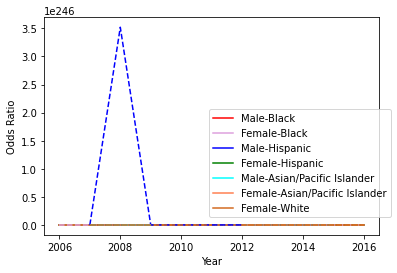

In [22]:
male_black = []
female_black = []	
male_asianpacific = []
female_asianpacific = []
male_hispanic = []
female_hispanic = []
female_white = []

male_black_low = []
female_black_low = []	
male_asianpacific_low = []
female_asianpacific_low = []
male_hispanic_low = []
female_hispanic_low = []
female_white_low = []

male_black_high = []
female_black_high = []	
male_asianpacific_high = []
female_asianpacific_high = []
male_hispanic_high = []
female_hispanic_high = []
female_white_high = []

generate_outputs(folder_path ='/content/drive/MyDrive/traffic_stop/output_inter/', with_vio = False, violation_types = None, speeding_only = True)